# Climate Data Cleaning
## 90-803 Machine Learning Foundations with Python (Spring 2024)
### Team 17: Yoko, Tessa, Hannah

In [1]:
# importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Transfering the Data into a Dataframe

> **Initial Observations:** The folder "climate_data_csv" that we scraped contains 288 .csv files. Each file contains the average temperature of counties in the U.S. in a specific month. In all, the entire folder contains monthly temperature data from 2000 to 2023. <br><br>
>Each file's name is associated with a code from 200001 to 202312 with the first 4 digits identifying the year and the last two digits identifying the month. For example, the file '110-tavg-200001-1.csv' has the code '200001' which can be broken up into '2000-01'. This means that the file contains the average temperature across counties for January 2000. To automate the process of reading all the files into a dataframe, we need a list of all these "codes" and a corresponding list of all the month in datetime format (the .csv files do not contain a "date" column).

In [2]:
#creating a list of the csv's unique codes
codeList = [200000+j+i for i in range(1,13) for j in range(0, 2400, 100)]
codeList.sort()

#print the first 5 values and the length of the list to double check
print('First 5 Values of List: ',codeList[:5])
print('Length of List: ', len(codeList)) # should be 288 items corresponding to 288 files available

First 5 Values of List:  [200001, 200002, 200003, 200004, 200005]
Length of List:  288


In [3]:
#create a range of dates that match each .csv, using end of month to be consistent with the housing dataset
data_range = list(pd.date_range(start = '1/31/2000', end='12/31/2023', freq= 'M'))
print(data_range[:5])

[Timestamp('2000-01-31 00:00:00'), Timestamp('2000-02-29 00:00:00'), Timestamp('2000-03-31 00:00:00'), Timestamp('2000-04-30 00:00:00'), Timestamp('2000-05-31 00:00:00')]


C:\Users\quint\AppData\Local\Temp\ipykernel_10460\1753313306.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_range = list(pd.date_range(start = '1/31/2000', end='12/31/2023', freq= 'M'))


> **Notes:** The first time we tried to read the files into pandas, it throws an exception that one of the rows was invalid. We found that there is 1 row in every dataset that was not parsed correctly (row 1188 for Washington, DC). We did not want to skip this row (using on_bad_lines = 'skip' in pd.read_csv()) because DC is such an important city in the U.S. This parsing error seem to be consistent in all .csv files so we will handle it separately. The next three cells illustrates the issue.

In [4]:
# illustration 1: what row 1188 looks like in every .csv files
temp = pd.read_csv('climate_data_csv/110-tavg-%s-1.csv' % (str(200001)), header= None, skiprows=1187, nrows=1)
temp

,0,1,2,3,4,5,6,7,8
0,MD-511,Washington,D.C.,Washington,D.C.,33.9,68,0.1,33.8


In [5]:
# illustration 2: what other rows look like in every .csv files
temp2 = pd.read_csv('climate_data_csv/110-tavg-%s-1.csv' % (str(200001)), header= None, skiprows = 5, nrows=3)
temp2

,0,1,2,3,4,5,6
0,AL-001,Autauga County,Alabama,47.9,86,1.6,46.3
1,AL-003,Baldwin County,Alabama,53.5,95,2.5,51.0
2,AL-005,Barbour County,Alabama,49.3,84,1.5,47.8


> As you can see, the Washington, DC rows have 8 columns instead of 6 like other rows, creating an inconsistency that pandas cannot parse automatically. We can handle this by taking them out individually and cutting out 3 and 4.

In [6]:
# illustration 3: taking out repeated columns 3 and 4
temp.drop(columns=[3,4],inplace=True)
temp

,0,1,2,5,6,7,8
0,MD-511,Washington,D.C.,33.9,68,0.1,33.8


In [7]:
# iterate through all the .csv in the folder and concatinate them into a dataframe

climate = pd.DataFrame()
shapes = [] # this list will contain the total rows of each dataset, we will use it to double check that we have collected all the rows later

for i in range(0,len(codeList)):

    #read in all csv, ignoring row 1188 (Washington, DC)
    myfile = pd.read_csv("climate_data_csv/110-tavg-%s-1.csv" % (str(codeList[i])), header=4, on_bad_lines="skip")

    #read in row 1188 and drop the repeated columns with index 3 and 4
    dc = pd.read_csv("climate_data_csv/110-tavg-%s-1.csv" % (str(codeList[i])),header=None, skiprows=1187, nrows=1)
    dc = dc.drop(columns=[3,4])

    #renaming the columns in dc so it can correctly concatinate to myfiles
    dc = dc.rename(columns = dict(zip(dc.columns, myfile.columns)))
    myfile = pd.concat([myfile, dc], axis=0, ignore_index=True)

    #dropping "rank" which is unnecessary for our analysis
    myfile = myfile.drop(columns='Rank')

    #adding a column for the date of the rows, all rows in each .csv file will share the same date
    myfile['Date'] = data_range[i]

    #appending the total rows of each file to a list
    shapes.append(myfile.shape[0])

    #concating each files to the overall climate dataframe
    climate = pd.concat([climate, myfile],axis=0, ignore_index=True)

#checking the first few rows
climate.head()

,ID,Name,State,Value,Anomaly (1901-2000 base period),1901-2000 Mean,Date
0,AL-001,Autauga County,Alabama,47.9,1.6,46.3,2000-01-31
1,AL-003,Baldwin County,Alabama,53.5,2.5,51.0,2000-01-31
2,AL-005,Barbour County,Alabama,49.3,1.5,47.8,2000-01-31
3,AL-007,Bibb County,Alabama,46.1,1.8,44.3,2000-01-31
4,AL-009,Blount County,Alabama,42.4,0.8,41.6,2000-01-31


In [8]:
# check that the total rows of each file read in is equal to the total rows of climate
print('Total rows of .csv files:', sum(shapes))
print('Shape of Climate', climate.shape)

Total rows of .csv files: 894816
Shape of Climate (894816, 7)


> We have all the rows and are ready for exploratory analysis!

## Making Sure the DataFrame is Ready for Analysis

In [9]:
# Check the data types of each column
climate.dtypes

ID                                         object
Name                                       object
State                                      object
Value                                     float64
Anomaly (1901-2000 base period)           float64
1901-2000 Mean                            float64
Date                               datetime64[ns]
dtype: object

In [10]:
# Descriptive statistics
climate.describe()

,Value,Anomaly (1901-2000 base period),1901-2000 Mean,Date
count,894816.000000,894816.000000,894816.000000,894816
mean,55.223378,1.411081,53.812965,2012-01-14 21:30:00
min,-7.900000,-24.100000,-0.200000,2000-01-31 00:00:00
25%,42.200000,-0.700000,40.700000,2006-01-23 06:00:00
50%,56.800000,1.300000,55.200000,2012-01-15 12:00:00
75%,70.000000,3.400000,68.800000,2018-01-07 18:00:00
max,97.600000,22.100000,91.700000,2023-12-31 00:00:00
std,17.655786,3.453320,17.783845,NaN


In [11]:
# NaN values
climate.isnull().sum()

ID                                 0
Name                               0
State                              0
Value                              0
Anomaly (1901-2000 base period)    0
1901-2000 Mean                     0
Date                               0
dtype: int64

> **Interpretation:** All columns are of the right type. The lowest monthly temperature in the U.S. from 2000 to 2023 is -7.9 and the highest is 97.6 Fahrenheits. The mean temperature is 55.22 Fahrenheits with a standard deviation of 17.656, and the median temperature is 56.8 Fahrenheits. There are no NaN values; the climate variable is ready for analysis.

## Exploratory Analysis

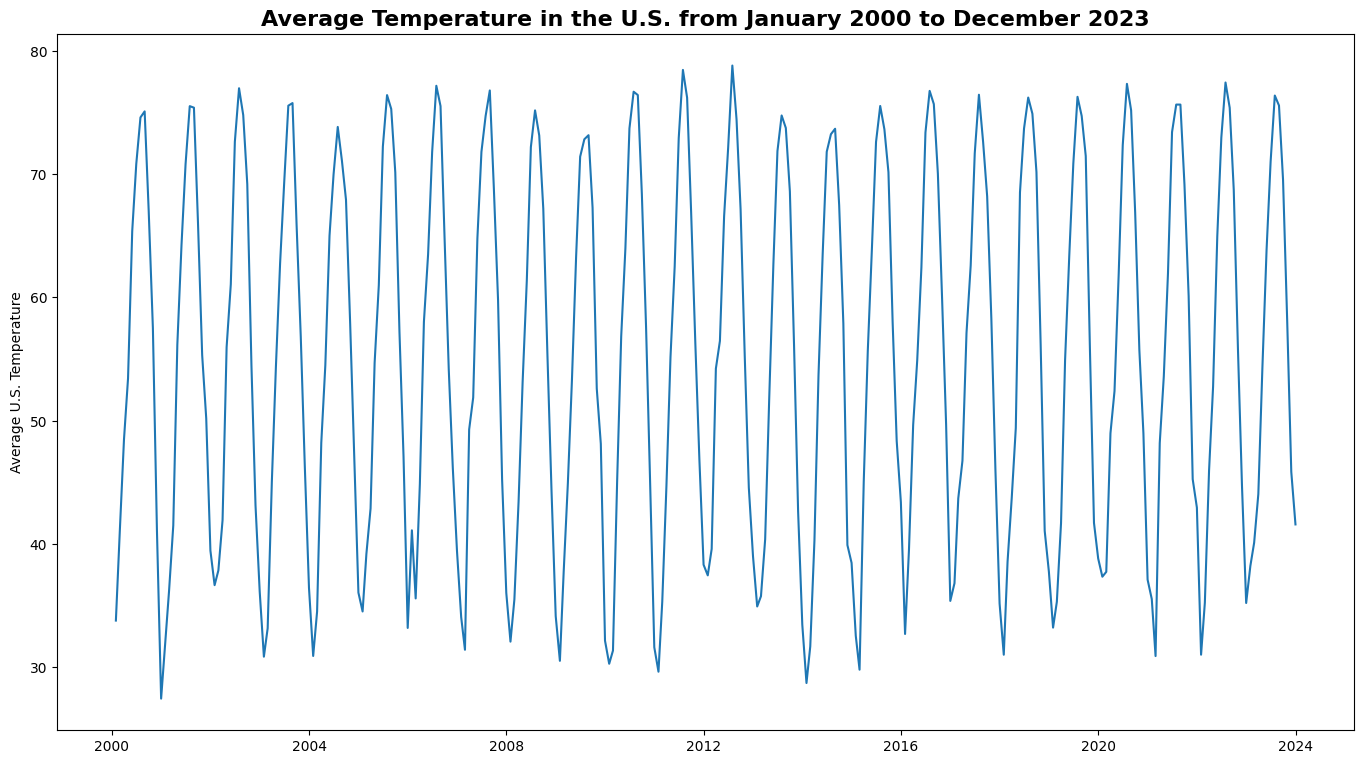

In [12]:
# average temperature in the U.S. overtime
plt.figure(figsize=(14,8))
sns.lineplot(data = climate[['Date','Value']].groupby('Date').mean().reset_index(), x = 'Date', y='Value').set(xlabel=None, ylabel = 'Average U.S. Temperature')
plt.title(label = 'Average Temperature in the U.S. from January 2000 to December 2023', fontsize=16, fontweight= 'bold')
plt.tight_layout(pad=2)
plt.show()

### Extracting the Cleaned Dataset into a Csv

In [13]:
climate.to_csv("climate_cleaned.csv", index=False)

### References
1. https://pandas.pydata.org/docs/reference/api/pandas.concat.html
2. https://stackoverflow.com/questions/993358/creating-a-range-of-dates-in-python
3. https://stackoverflow.com/questions/18039057/pandas-parser-cparsererror-error-tokenizing-data
4. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html